In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
from PIL import Image, ImageSequence
import os

import seaborn as sea
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline, SmoothBivariateSpline

In [2]:
sea.set(style="white")

In [3]:
def create_loss_manifold(sigfrac, m1, m2, z):

    start = 0.5
    end = 6
    step = 0.125

    weight_list = np.arange(start, end + step, step)

    grid_axes = []
    for w1 in weight_list:
        for w2 in weight_list:
            grid_axes.append((w1, w2))

    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])

    x = w1_values
    y = w2_values
    z = loss_values

    sea.set(style="whitegrid")
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='r', marker='.', alpha = 0.1)
    ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

    ax.set_xlabel('W1')
    ax.set_ylabel('W2')
    ax.set_zlabel('Loss')
    ax.set_title("Loss Manifold m1: {} m2: {} sigfrac: {}".format(m1, m2, np.round(sigfrac, 4)))

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.grid(False)
    
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=40, azim=10)
    plt.savefig('plot.png', dpi=450, bbox_inches='tight')
    return ax

In [22]:
z_allm1m2_4HD = np.load("z_allm1m2_4FeaturesHD.npy", allow_pickle = True).item()
z_allm1m2_4HD.keys()

dict_keys([(0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.0379269019073225, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5), (0.001, 1, 5.5), (0.0012742749857031334, 1, 5.5), (0.001623776739188721, 1, 5.5), (0.00206913808111479, 1, 5.5), (0.0026366508987303583, 1, 5.5), (0.003359818286283781, 1, 5.5), (0.004281332398719396, 1, 5.5), (0.00545559478116852, 1, 5.5), (0.0069519279617756054, 1, 5.5), (0.008858667904100823, 1, 5.5), (0.011288378916846888, 1, 5.5), (0.01438449888287663, 1, 5.5), (0.01832980710832

In [23]:
z_allm1m2_6HD = np.load("z_allm1m2_6FeaturesHD.npy", allow_pickle = True).item()
z_allm1m2_6HD.keys()

dict_keys([(0.0379269019073225, 3, 4.5), (0.001, 3, 4.5), (0.0012742749857031334, 3, 4.5), (0.001623776739188721, 3, 4.5), (0.00206913808111479, 3, 4.5), (0.0026366508987303583, 3, 4.5), (0.003359818286283781, 3, 4.5), (0.004281332398719396, 3, 4.5), (0.00545559478116852, 3, 4.5), (0.0069519279617756054, 3, 4.5), (0.008858667904100823, 3, 4.5), (0.011288378916846888, 3, 4.5), (0.01438449888287663, 3, 4.5), (0.018329807108324356, 3, 4.5), (0.023357214690901212, 3, 4.5), (0.029763514416313176, 3, 4.5), (0.04832930238571752, 3, 4.5), (0.06158482110660261, 3, 4.5), (0.07847599703514611, 3, 4.5), (0.1, 3, 4.5), (0.001, 3, 3), (0.0012742749857031334, 3, 3), (0.001623776739188721, 3, 3), (0.00206913808111479, 3, 3), (0.0026366508987303583, 3, 3), (0.003359818286283781, 3, 3), (0.004281332398719396, 3, 3), (0.00545559478116852, 3, 3), (0.0069519279617756054, 3, 3), (0.008858667904100823, 3, 3), (0.011288378916846888, 3, 3), (0.01438449888287663, 3, 3), (0.018329807108324356, 3, 3), (0.02335721

In [4]:
z_allm1m2_6HDER = np.load("z_allm1m2_6FeaturesHigherRes.npy", allow_pickle = True).item()
z_allm1m2_6HDER.keys()

dict_keys([(0.001, 3.5, 5.5), (0.1, 3.5, 5.5)])

In [4]:
z_allm1m2_3Pronged6 = np.load("z_allm1m2_63Pronged.npy", allow_pickle = True).item()
z_allm1m2_3Pronged6.keys()

dict_keys([(0.1, 3.5, 5.5)])

<Axes3D: title={'center': 'Loss Manifold m1: 3.5 m2: 5.5 sigfrac: 0.1'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

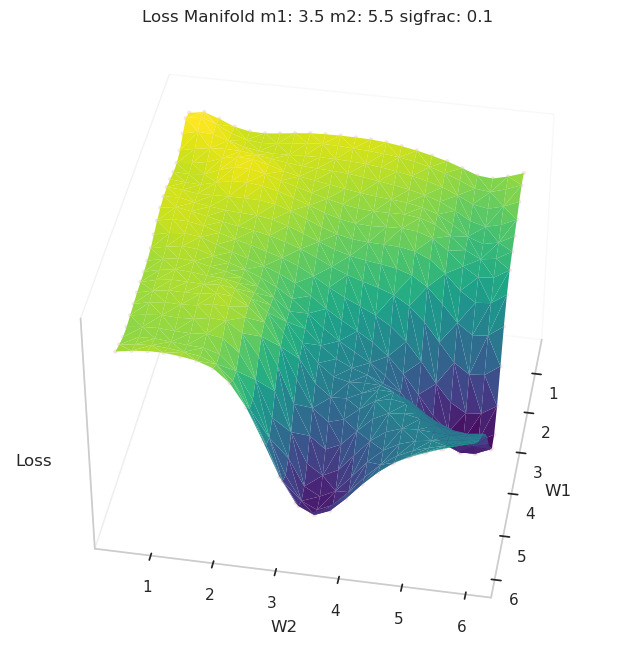

In [6]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(sig_space[19], 3.5, 5.5, z_allm1m2_3Pronged6)

<Axes3D: title={'center': 'Loss Manifold m1: 1 m2: 5.5 sigfrac: 0.1'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

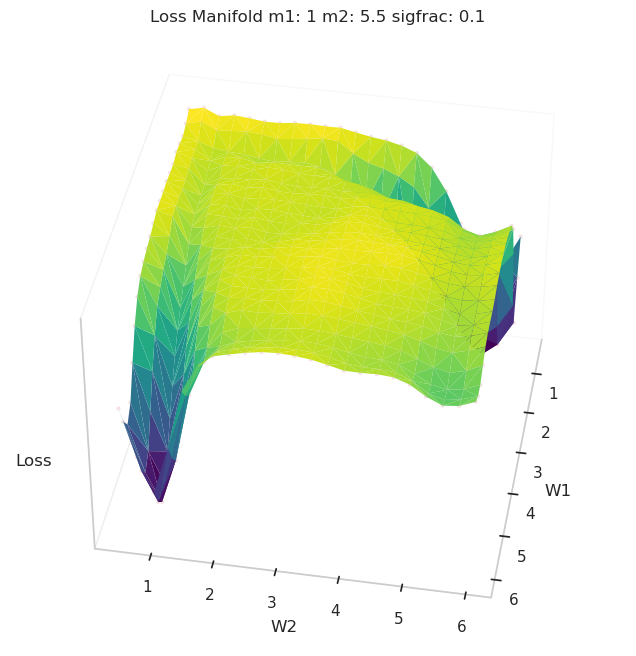

In [15]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(sig_space[19], 1, 5.5, z_allm1m2_4HD)

<Axes3D: title={'center': 'Loss Manifold m1: 3.5 m2: 5.5 sigfrac: 0.001'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

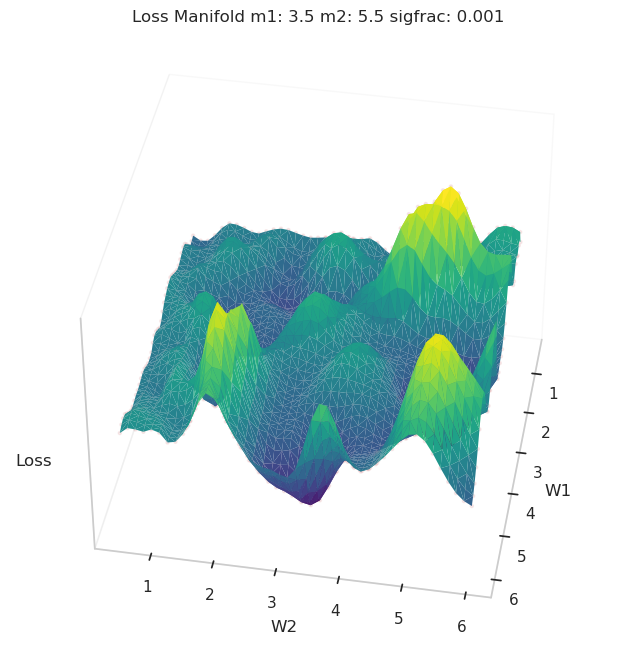

In [12]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(0.001, 3.5, 5.5, z_allm1m2_6HD)

In [25]:
def loss_landscape_nofit(sigfrac, m1, m2, z):
    
    #create grid of points for the model to be evaluated at
    
    start = 0.5
    end = 6
    step = 0.25/4

    weight_list = np.arange(start, end + step, step)
    
    grid_axes = []
    for w1 in weight_list:
        for w2 in weight_list:
            grid_axes.append((w1, w2))
            
    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(w1_values, w2_values, bins=(89,89), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    #plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('6 Features (m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    plt.savefig('plot2D.png', dpi=450, bbox_inches='tight')
    return h

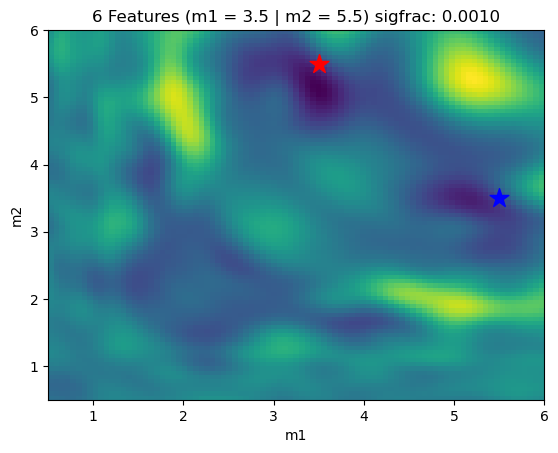

In [26]:
loss_landscape_nofit(0.001, 3.5, 5.5, z_allm1m2_6HDER);

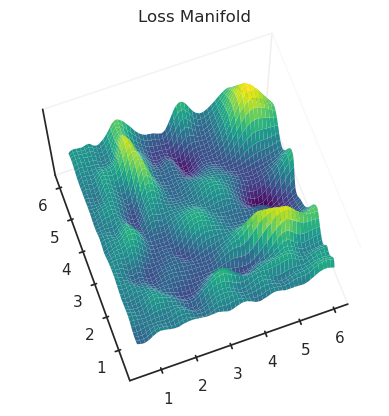

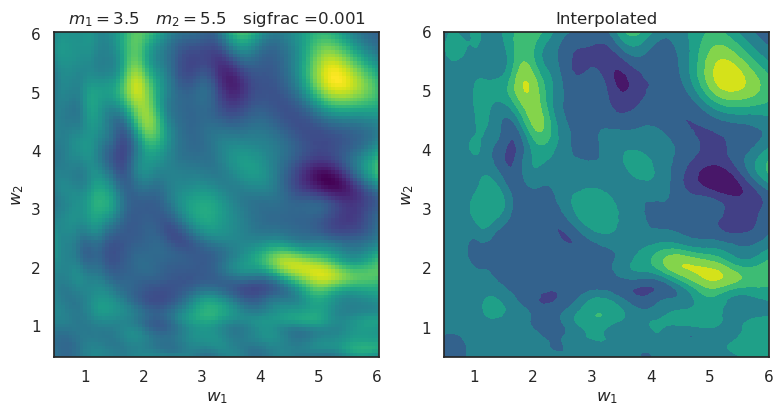

In [119]:
def plot_interpolated_landscape(sigfrac, m1, m2, z):
    
    start = 0.5
    end = 6
    step = 0.25/4

    weight_list = np.arange(start, end + step, step)

    x_values = weight_list
    y_values = weight_list

    x, y = np.meshgrid(x_values, y_values)

    loss_values_flat = z[sigfrac, m1, m2]
    loss_values = np.array(loss_values_flat).reshape(x.shape)

    interp_spline = RectBivariateSpline(x_values, y_values, loss_values, s = 0)

    xi, yi = np.meshgrid(np.linspace(min(x_values), max(x_values), 1000), np.linspace(min(y_values), max(y_values), 1000))
    zi = interp_spline(xi[0, :], yi[:, 0])
    
    #3d projection
    fig = plt.figure()
    ax3d = fig.add_subplot(111, projection='3d')
    ax3d.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', linewidth = 0)
    ax3d.set_title("Loss Manifold")
    ax3d.xaxis.pane.fill = False
    ax3d.yaxis.pane.fill = False
    ax3d.zaxis.pane.fill = False

    ax3d.grid(False)
    
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax3d.set_zticks([])
    ax3d.view_init(elev=70, azim=250)

    #2d projection
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].pcolormesh(x, y, loss_values, cmap='viridis')
    ax[0].set_aspect("equal")
    ax[0].set_title(f"$m_{1} = {m1} \quad m_{2} = {m2} \quad$" + f"sigfrac ={sigfrac}")
    ax[0].set_xlabel(r"$w_{1}$")
    ax[0].set_ylabel(r"$w_{2}$")

    ax[1].contourf(xi, yi, zi, cmap='viridis')
    ax[1].set_aspect("equal")
    ax[1].set_title('Interpolated'.format(m1, m2, sigfrac))
    ax[1].set_xlabel(r"$w_{1}$")
    ax[1].set_ylabel(r"$w_{2}$")

    plt.tight_layout()
    #plt.savefig('interpolation3.55.5.png', dpi=450, bbox_inches='tight')
    return fig

plot_interpolated_landscape(0.001, 3.5, 5.5, z_allm1m2_6HDER)
plt.show()

In [224]:
def create_gif_manifold(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 40)
    
    frames = []
    for sig in sig_space[:15]:
    
        create_loss_manifold(sig, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sig}.png')
        plt.savefig(image_path, dpi = 450, bbox_inches='tight')
        plt.close()
        clear_output(wait=True)

        frames.append(Image.open(image_path))

    output_gif_filename = f'LossManifoldformated_HighRes6{m1}{m2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)
    
    #plt.savefig('plot.png', dpi=450, bbox_inches='tight')

In [225]:
create_gif_manifold(3.5, 5.5, z_allm1m2_6HD)

In [125]:
max_sics = np.load('max_sics_24.5.npz')
msic1_runs = max_sics["SWS"]
msic2_runs = max_sics["WS"]
msic3_runs = max_sics["FS"]

In [78]:
sig_list = list(np.logspace(-3,-1,20))

Text(0, 0.5, 'Avg Max SIC')

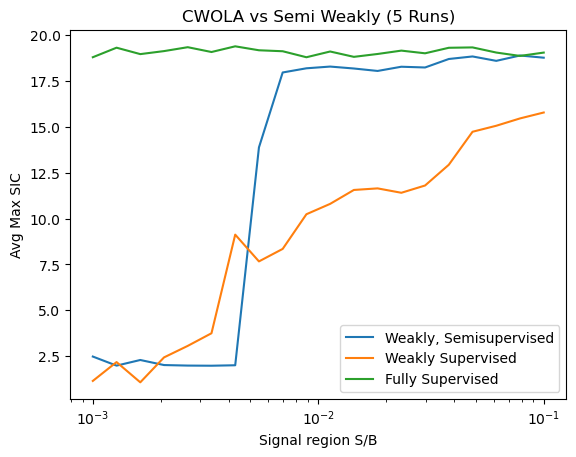

In [126]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

sea.reset_orig()
plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly (5 Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

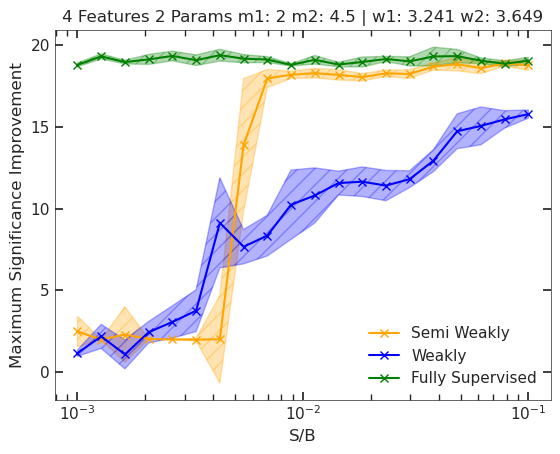

In [127]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

maxsic3 = [i[0] for i in avgmsic3]
msicstds3 = np.std(msic3_runs, axis = 0)
maxsicstd3 = np.array([i[0] for i in msicstds3])

#sea.reset_orig()
sea.set(style="white")
plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green')

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

sea.set(style="white")
plt.xlabel('S/B')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'4 Features 2 Params m1: {2} m2: {4.5} | w1: {3.241} w2: {3.649}')
plt.xscale("log")
plt.legend(frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')

plt.show()

In [115]:
import pickle
with open('max_sics_33.pkl', 'rb') as f:
    loaded_max_sics = pickle.load(f)

In [116]:
# Access the array using the tuple key
msic1_runs = loaded_max_sics[("SWS", 3, 3, 3.241, 3.649)]
msic2_runs = loaded_max_sics[("WS", 3, 3, 3.241, 3.649)]
msic3_runs = loaded_max_sics[("FS", 3, 3, 3.241, 3.649)]

Text(0, 0.5, 'Avg Max SIC')

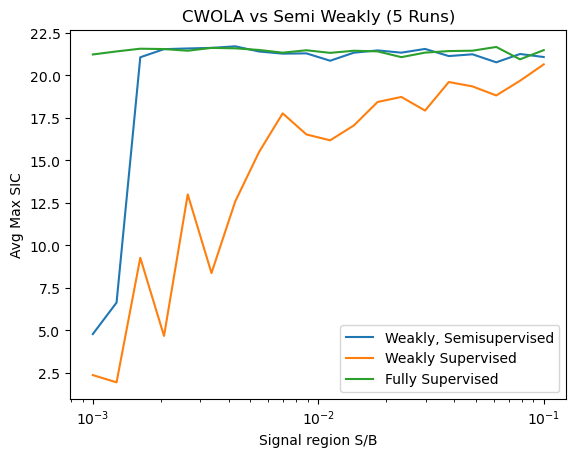

In [117]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

sea.reset_orig()
plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly (5 Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

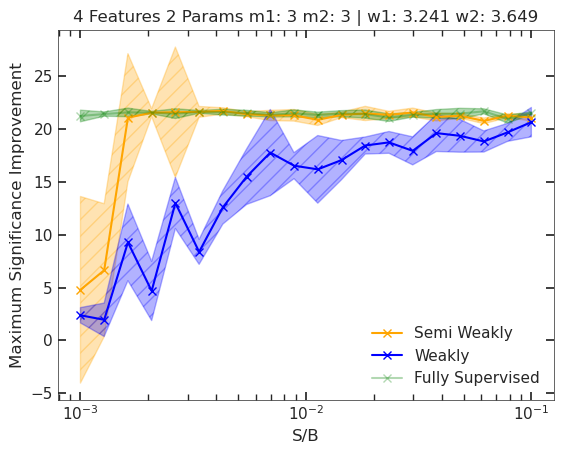

In [123]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

maxsic3 = [i[0] for i in avgmsic3]
msicstds3 = np.std(msic3_runs, axis = 0)
maxsicstd3 = np.array([i[0] for i in msicstds3])

#sea.reset_orig()
sea.set(style="white")
plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green',alpha = 0.3)

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

sea.set(style="white")
plt.xlabel('S/B')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'4 Features 2 Params m1: {3} m2: {3} | w1: {3.241} w2: {3.649}')
plt.xscale("log")
plt.legend(loc="lower right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')
plt.show()

In [129]:
with open('max_sics_33_3param.pkl', 'rb') as f:
    loaded_max_sics = pickle.load(f)

msic1_runs = loaded_max_sics[("SWS", 3, 3, 3, 3.241, 3.649)]
msic2_runs = loaded_max_sics[("WS",3, 3, 3, 3.241, 3.649)]
msic3_runs = loaded_max_sics[("FS",3, 3, 3, 3.241, 3.649)]

Text(0, 0.5, 'Avg Max SIC')

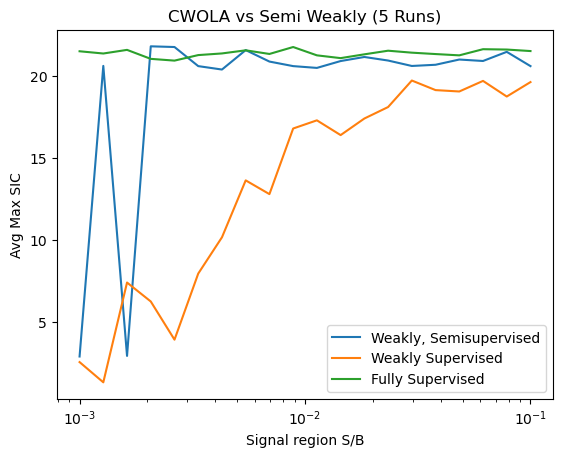

In [130]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

sea.reset_orig()
plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly (5 Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

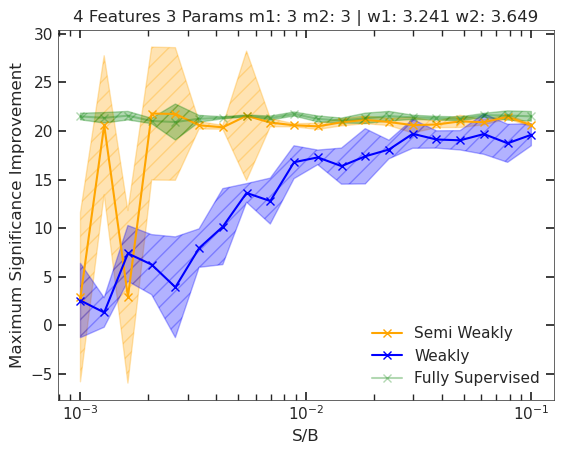

In [169]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

maxsic3 = [i[0] for i in avgmsic3]
msicstds3 = np.std(msic3_runs, axis = 0)
maxsicstd3 = np.array([i[0] for i in msicstds3])

#sea.reset_orig()
sea.set(style="white")
plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green',alpha = 0.3)

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

sea.set(style="white")
plt.xlabel('S/B')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'4 Features 3 Params m1: {3} m2: {3} | w1: {3.241} w2: {3.649}')
plt.xscale("log")
plt.legend(loc="lower right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')
plt.show()

In [132]:
ww_runs = np.load('4Features3Param33Perturb_WEIGHTLIST.npy')

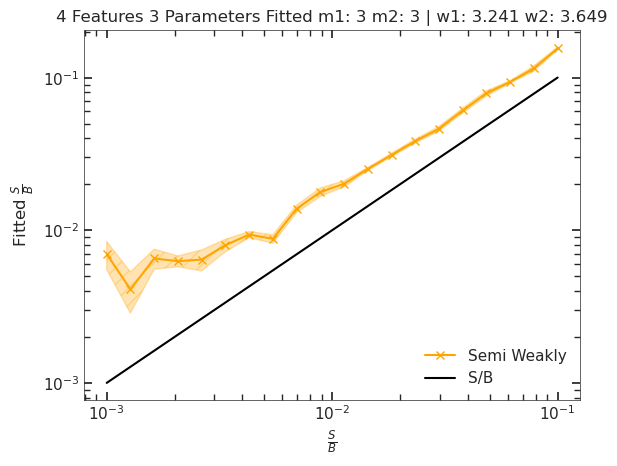

In [143]:
signal_fraction_values = np.logspace(-3, -1, 20)
avgww = np.median(ww_runs, axis = 0)

fittedw = avgww
fittedwstd = np.std(ww_runs, axis = 0)

plt.plot(signal_fraction_values, fittedw, marker = "x", label='Semi Weakly', color='orange')
plt.plot(sig_list, sig_list, marker = "", label='S/B', color='black')

plt.fill_between(signal_fraction_values, fittedw - fittedwstd, fittedw + fittedwstd, color='orange', alpha=0.3, hatch = "//")

plt.xlabel(r'$\frac{S}{B}$')

plt.ylabel(r'Fitted $\frac{S}{B}$')
plt.title(f'4 Features 3 Parameters Fitted m1: {3} m2: {3} | w1: {3.241} w2: {3.649}')
plt.yscale("log")
plt.xscale("log")
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.legend(loc="lower right",frameon=False)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')
plt.show()

In [194]:
with open('max_sics_3.55.5_6Feature3param.pkl', 'rb') as f:
    loaded_max_sics = pickle.load(f)

In [195]:
m1, m2 = 3.5, 5.5
w1 = 2
w2 = 5
msic1_runs = loaded_max_sics[("SWS", 6, 3, m1, m2, w1, w2)]
msic2_runs = loaded_max_sics[("WS", 6, 3, m1, m2, w1, w2)]
msic3_runs = loaded_max_sics[("FS", 6, 3, m1, m2, w1, w2)]

Text(0, 0.5, 'Avg Max SIC')

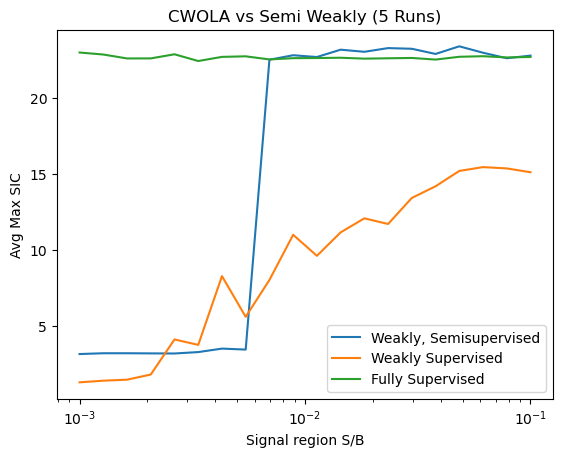

In [196]:
sig_list = np.logspace(-3, -1, 20)
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

sea.reset_orig()
plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly (5 Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

In [207]:
start = 0.5
end = 6
step = 0.125

weight_list = np.arange(start, end + step, step)
len(weight_list)

45

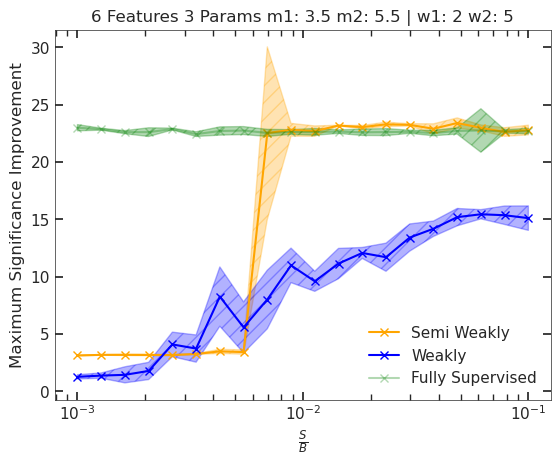

In [203]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

maxsic3 = [i[0] for i in avgmsic3]
msicstds3 = np.std(msic3_runs, axis = 0)
maxsicstd3 = np.array([i[0] for i in msicstds3])

#sea.reset_orig()
sea.set(style="white")
plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green',alpha = 0.3)

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

sea.set(style="white")
plt.xlabel(r'$\frac{S}{B}$')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'6 Features 3 Params m1: {3.5} m2: {5.5} | w1: {2} w2: {5}')
plt.xscale("log")
plt.legend(loc="lower right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.savefig('maxsicplot.png', dpi=450, bbox_inches='tight')
plt.show()

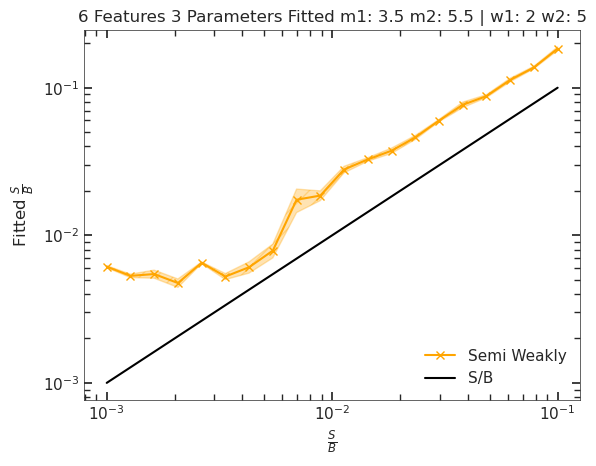

In [202]:
ww_runs = np.load("6paramweights3.55.5Perturb.npy")
signal_fraction_values = np.logspace(-3, -1, 20)
avgww = np.median(ww_runs, axis = 0)

fittedw = avgww
fittedwstd = np.std(ww_runs, axis = 0)

plt.plot(signal_fraction_values, fittedw, marker = "x", label='Semi Weakly', color='orange')
plt.plot(sig_list, sig_list, marker = "", label='S/B', color='black')

plt.fill_between(signal_fraction_values, fittedw - fittedwstd, fittedw + fittedwstd, color='orange', alpha=0.3, hatch = "//")

plt.xlabel(r'$\frac{S}{B}$')

plt.ylabel(r'Fitted $\frac{S}{B}$')
plt.title(f'6 Features 3 Parameters Fitted m1: {3.5} m2: {5.5} | w1: {2} w2: {5}')
plt.yscale("log")
plt.xscale("log")
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.legend(loc="lower right",frameon=False)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')
plt.show()

In [4]:
import pickle
with open('max_sics_3prong33.pkl', 'rb') as f:
    loaded_max_sics = pickle.load(f)

m1, m2 = 3, 3
w1, w2 = 3.241, 3.649
msic1_runs = loaded_max_sics[("SWS", 6, 4, m1, m2)]
msic2_runs = loaded_max_sics[("WS", 6, 4, m1, m2)]

Text(0, 0.5, 'Avg Max SIC')

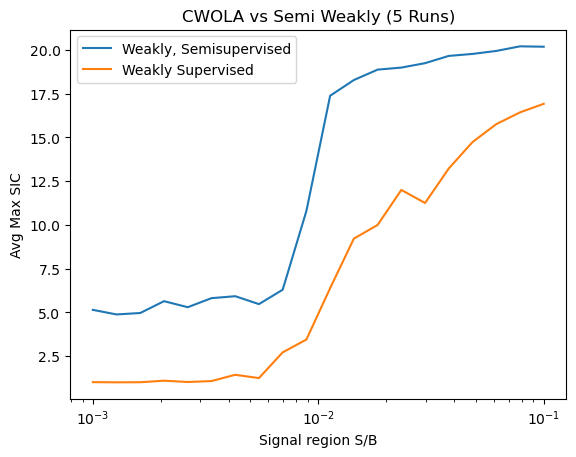

In [6]:
sig_list = np.logspace(-3, -1, 20)
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
#avgmsic3 = np.median(msic3_runs, axis = 0)

sea.reset_orig()
plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
#plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly (5 Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

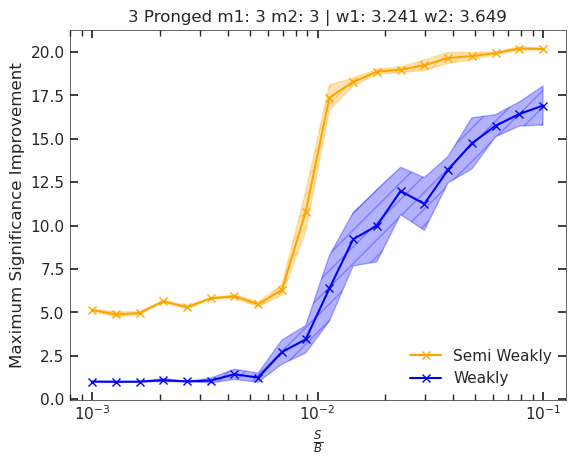

In [8]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

# maxsic3 = [i[0] for i in avgmsic3]
# msicstds3 = np.std(msic3_runs, axis = 0)
# maxsicstd3 = np.array([i[0] for i in msicstds3])

#sea.reset_orig()
sea.set(style="white")
plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
#plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green',alpha = 0.3)

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
#plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

sea.set(style="white")
plt.xlabel(r'$\frac{S}{B}$')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'3 Pronged m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend(loc="lower right",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.savefig('maxsicplot3prong.png', dpi=450, bbox_inches='tight')
plt.show()

In [39]:
with open('max_sics_3prong33pertb.pkl', 'rb') as f:
    loaded_max_sics = pickle.load(f)

m1, m2 = 3, 3
w1, w2 = 3.241, 3.649
msic1_runs = loaded_max_sics[("SWS", 6, 4, m1, m2, w1, w2)]
msic2_runs = loaded_max_sics[("WS", 6, 4, m1, m2, w1, w2)]
msic3_runs = loaded_max_sics[("FS", 6, 4, m1, m2, w1, w2)]

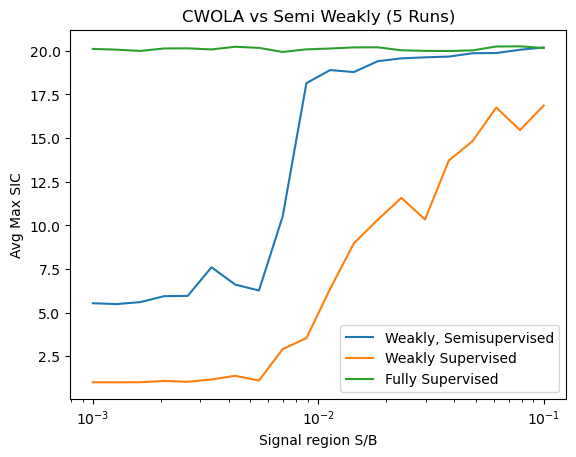

In [40]:
sig_list = np.logspace(-3, -1, 20)
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

sea.reset_orig()
plt.figure()
plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly (5 Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")
plt.show()

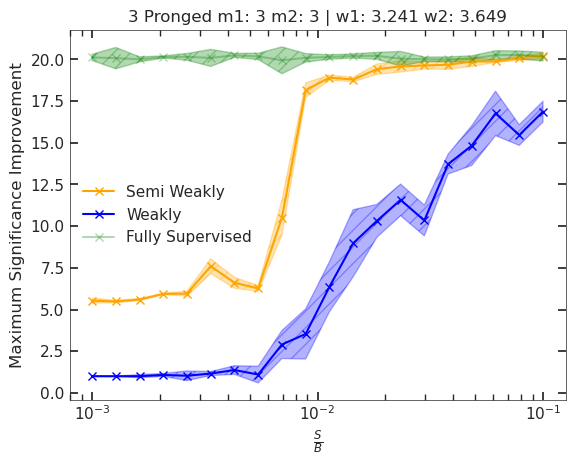

In [42]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

maxsic3 = [i[0] for i in avgmsic3]
msicstds3 = np.std(msic3_runs, axis = 0)
maxsicstd3 = np.array([i[0] for i in msicstds3])

#sea.reset_orig()
plt.figure()
sea.set(style="white")
plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green',alpha = 0.3)

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

sea.set(style="white")
plt.xlabel(r'$\frac{S}{B}$')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'3 Pronged m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend(loc="center left",frameon=False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.savefig('maxsicplot3prong33perturb.png', dpi=450, bbox_inches='tight')
plt.show()

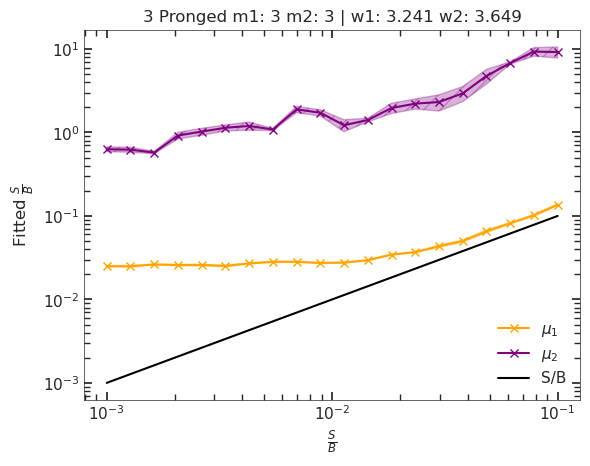

In [44]:
ww3_runs = np.load("3ProngWeight_List3_Runs33.npy")
ww4_runs = np.load("3ProngWeight_List4_Runs33.npy")

signal_fraction_values = np.logspace(-3, -1, 20)
avgww = np.median(ww3_runs, axis = 0)
avgww2 = np.median(ww4_runs, axis = 0)

fittedw = avgww
fittedwstd = np.std(ww3_runs, axis = 0)

fittedw2 = avgww2
fittedwstd2 = np.std(ww4_runs, axis = 0)

plt.figure()
plt.plot(signal_fraction_values, fittedw, marker = "x", label=r"$\mu_{1}$", color='orange')
plt.plot(signal_fraction_values, fittedw2, marker = "x", label=r"$\mu_{2}$", color='purple')

plt.plot(sig_list, sig_list, marker = "", label='S/B', color='black')

plt.fill_between(signal_fraction_values, fittedw - fittedwstd, fittedw + fittedwstd, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, fittedw2 - fittedwstd2, fittedw2 + fittedwstd2, color='purple', alpha=0.3, hatch = "//")

plt.xlabel(r'$\frac{S}{B}$')
plt.ylabel(r'Fitted $\frac{S}{B}$')
plt.title(f'3 Pronged m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.yscale("log")
plt.xscale("log")
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)
plt.legend(loc="lower right",frameon=False)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')
plt.show()